## Measurement Architecture Example

A simple example, with simulated data.

This simple example **do not consider any type of customer segmentation**. To implement it, you could add a customer dimension table or add customer info inside metric store.

In [37]:
import pandas as pd
import numpy as np
from random import sample
import itertools
import datetime
import ipywidgets as widgets
from croniter import croniter
from IPython.display import display, Image
import shutil
import findspark
findspark.init()



import pyspark
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DateType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression

spark = SparkSession.builder.getOrCreate()
shutil.rmtree('spark-warehouse', ignore_errors=True)

master = "local"
appName = "Simple Measururement Architecture"
spark = SparkSession.builder \
    .appName(appName) \
    .master(master) \
    .enableHiveSupport() \
    .getOrCreate()

### 0. The basic Tables
In this section the basic tables to a measurement architecture are created. The important point here is: all data created must be followed by the metadata that completely describe it.

All architecture described here depends on 6 tables, 3 for metrics and 3 for experiments, as described bellow:

![alt text](MetricStore.drawio.png "Tables Description")

In [2]:
# Creating Metric Store
all_customers = ['customer_' + str(ii) for ii in range(0,1000)]
def create_metric_store(all_customers):
    ndays = 90
    
    all_dates = pd.date_range(datetime.datetime.today()- datetime.timedelta(days=ndays) , periods=ndays).tolist()

    df_metric_store_base = pd.DataFrame(list(itertools.product(all_customers, all_dates)), columns=['CUSTOMER', 'DATE'])
    df_metric_store_base['DATE'] = df_metric_store_base['DATE'].dt.date
    df_metric_store_base['VARIATION'] = 'N/A'
    df_metric_store_1 = df_metric_store_base.copy()
    df_metric_store_1['METRIC'] = 'sales'
    df_metric_store_1['VALUE'] = np.random.randint(0,1000,size=df_metric_store_1.shape[0])

    df_metric_store_2 = df_metric_store_base.copy()
    df_metric_store_2['METRIC'] = 'churn'
    df_metric_store_2['VALUE'] = np.random.randint(0,1000,size=df_metric_store_2.shape[0])/1000

    df_metric_store = df_metric_store_1.append(df_metric_store_2)
    df_metric_store = df_metric_store.reset_index(drop = True)
    df_metric_store = spark.createDataFrame(df_metric_store)
    df_metric_store = df_metric_store.select(['CUSTOMER', 'DATE', 'VARIATION', 'METRIC', 'VALUE'])
    df_metric_store.write.mode("overwrite").saveAsTable("df_metric_store")

create_metric_store(all_customers)
df_metric_store = spark.sql("select * from df_metric_store")
df_metric_store.show()

+------------+----------+---------+------+-----+
|    CUSTOMER|      DATE|VARIATION|METRIC|VALUE|
+------------+----------+---------+------+-----+
|customer_750|2021-11-30|      N/A| sales|481.0|
|customer_750|2021-12-01|      N/A| sales|525.0|
|customer_750|2021-12-02|      N/A| sales|665.0|
|customer_750|2021-12-03|      N/A| sales|314.0|
|customer_750|2021-12-04|      N/A| sales|722.0|
|customer_750|2021-12-05|      N/A| sales|424.0|
|customer_751|2021-09-07|      N/A| sales|152.0|
|customer_751|2021-09-08|      N/A| sales|716.0|
|customer_751|2021-09-09|      N/A| sales|815.0|
|customer_751|2021-09-10|      N/A| sales|603.0|
|customer_751|2021-09-11|      N/A| sales|281.0|
|customer_751|2021-09-12|      N/A| sales|217.0|
|customer_751|2021-09-13|      N/A| sales|506.0|
|customer_751|2021-09-14|      N/A| sales|712.0|
|customer_751|2021-09-15|      N/A| sales|920.0|
|customer_751|2021-09-16|      N/A| sales|257.0|
|customer_751|2021-09-17|      N/A| sales|632.0|
|customer_751|2021-0

In [3]:
# Creating Dummy Metadata
def create_metric_store_metadata():
    dict_metadata = {'METRIC': ['sales', 'churn'], 'TYPE': ['business', 'model'], 'RESPONSIBLE': ['xxxx@yourcompany.com', 'xxx@yourcompany.com'], 'DESCRIPTION': ['Total sales of a given customer across all channels and products', 'Probability of customer churn in 60 days. Computed by data science team, updated every week'], 'FREQUENCY': ['0 8 * * *', '0 15 * * 7'], 'QUERY': ['select ....from db.customer join ... where...', 'select ....from db.customer join ... where...']}
    df_metadata = spark.createDataFrame(pd.DataFrame.from_dict(dict_metadata))
    df_metadata.write.mode("overwrite").saveAsTable("df_metadata")
    
create_metric_store_metadata()
df_metadata = spark.sql("select * from df_metadata")
df_metadata.show()

+------+--------+--------------------+--------------------+----------+--------------------+
|METRIC|    TYPE|         RESPONSIBLE|         DESCRIPTION| FREQUENCY|               QUERY|
+------+--------+--------------------+--------------------+----------+--------------------+
| churn|   model| xxx@yourcompany.com|Probability of cu...|0 15 * * 7|select ....from d...|
| sales|business|xxxx@yourcompany.com|Total sales of a ...| 0 8 * * *|select ....from d...|
+------+--------+--------------------+--------------------+----------+--------------------+



As the query and the frequency in Cron format is in metadata table, your ETL process can read directly from this table and run the process. To keep governance, it is important to make sure that metrics are somehow audited before running.

For example, you could add an extra table, controlled by a centralized team, describing the status of each Metric

In [4]:
# Creating Metric Governance
def create_metric_store_governance():
    dict_metricgov = {'METRIC': ['sales', 'churn'], 'TYPE': ['business', 'model'], 'STATUS': ['Approved', 'In Revision']}
    df_metricgov= spark.createDataFrame(pd.DataFrame.from_dict(dict_metricgov))
    df_metricgov.write.mode("overwrite").saveAsTable("df_metricgov")
    
create_metric_store_governance()
df_metricgov = spark.sql("select * from df_metricgov")
df_metricgov.show()

+------+--------+-----------+
|METRIC|    TYPE|     STATUS|
+------+--------+-----------+
| sales|business|   Approved|
| churn|   model|In Revision|
+------+--------+-----------+



### 1. Support Functions
Some functions to operate our measurement architecture

In [5]:
# Support Functions
def save_table(df, name):
    df.write.mode("overwrite").saveAsTable("temp_table")
    dy = spark.table("temp_table")
    dy.write.mode("overwrite").insertInto(name)

def create_new_metric(name, type_metric, responsible, description, frequency, query):
    """
    Register new metric in Metric Store Metadata. This should be done every time a new metric is added in you store 
    Obs.: Add validations! Ex. metric type, frequency format, duplications
    
    - Suggestion: use hive table append
    
    """

    df_metadata = spark.sql("select * from df_metadata")    
    dict_meta_add = {'METRIC': [name], 'TYPE': [type_metric], 'RESPONSIBLE': [responsible], 'DESCRIPTION': [description], 'FREQUENCY': [frequency], 'QUERY': [query]}
    df_meta_add = spark.createDataFrame(pd.DataFrame.from_dict(dict_meta_add))
    df_metadata = df_meta_add.union(df_metadata)
    save_table(df_metadata, "df_metadata")


def upload_metric(df, date, metric, variation = 'N/A'):
    """ 
    To upload new data to Metric Store. 
    
    - df contains customer/ value for a specific day
    
    Obs.: Add validations! 
     
    - Suggestion: use hive table append
    
    """

    df_metadata = spark.sql("select * from df_metadata")
    df_metric_store = spark.sql("select * from df_metric_store")
    
    df = pd.DataFrame.from_dict(df)
    
    df = spark.createDataFrame(df)
    df = df.withColumn("METRIC", F.lit(metric))
    df = df.withColumn("VARIATION", F.lit(variation))
    df = df.withColumn("DATE", F.lit(date))
    
    df = df.withColumn("CUSTOMER",F.col("CUSTOMER").cast(StringType()))
    df = df.withColumn("VALUE",F.col("VALUE").cast(DoubleType()))
    df = df.withColumn("DATE",F.col("DATE").cast(DateType()))
    
    
    # Validates if metric is ok with metadata (user, frequency etc)
    df = df.join(df_metadata.select('METRIC'), on = 'METRIC', how = 'inner')
    # ... add validations
    
    df = df.select(['CUSTOMER', 'DATE', 'VARIATION', 'METRIC', 'VALUE'])
    df_metric_store = df_metric_store.select(['CUSTOMER', 'DATE', 'VARIATION', 'METRIC', 'VALUE'])
    
    # Append on top, for visualization
    if df.count() > 0:
        df_metric_store = df.union(df_metric_store)
    else:
        print("No rows added")

    save_table(df_metric_store, "df_metric_store")

### 2. Let's Operate this simple Metric Store!

Some examples to add new metric, or append metric to an existing metric.

Bellow, some cells that:
- `create_new_metric`: must be run a single time, once a new metric is created inside Metric Store. 
- `upload_metric`: Must be run according to your need, to update data from Metric Store. Often, this is once a day (for batch process) or realtime

Suggestion is to centralized all metric creation and data upload (see the end of this notebook for an example), to facilitate governance!

Obs.: All these functions can be turned into APIs!

In [6]:
# If you want to add a new Metric to your store, run this a single time
# Web Navigation Metric
df_metadata = create_new_metric(name = 'web_navigation', type_metric = 'engajament', responsible = 'zzzz@yourcompany.com', description = "Total hit points of a page defined in column 'variation'", frequency = '0 9 * * *', query = 'select .... from ....')
df_metadata = spark.sql("select * from df_metadata")
df_metadata.show()

+--------------+----------+--------------------+--------------------+----------+--------------------+
|        METRIC|      TYPE|         RESPONSIBLE|         DESCRIPTION| FREQUENCY|               QUERY|
+--------------+----------+--------------------+--------------------+----------+--------------------+
|         churn|     model| xxx@yourcompany.com|Probability of cu...|0 15 * * 7|select ....from d...|
|         sales|  business|xxxx@yourcompany.com|Total sales of a ...| 0 8 * * *|select ....from d...|
|web_navigation|engajament|zzzz@yourcompany.com|Total hit points ...| 0 9 * * *|select .... from ...|
+--------------+----------+--------------------+--------------------+----------+--------------------+



In [7]:
# Example including that on Metric Store
df_append_store = {'CUSTOMER': ['customer_200', 'customer_9872'], 'VALUE': [190, 30]}
upload_metric(df_append_store, date='2021-11-30', metric='sales')
df_metric_store = spark.sql("select * from df_metric_store where METRIC = 'sales'")
df_metric_store.show(5)

+------------+----------+---------+------+-----+
|    CUSTOMER|      DATE|VARIATION|METRIC|VALUE|
+------------+----------+---------+------+-----+
|customer_750|2021-11-30|      N/A| sales|481.0|
|customer_750|2021-12-01|      N/A| sales|525.0|
|customer_750|2021-12-02|      N/A| sales|665.0|
|customer_750|2021-12-03|      N/A| sales|314.0|
|customer_750|2021-12-04|      N/A| sales|722.0|
+------------+----------+---------+------+-----+
only showing top 5 rows



In [8]:
# Another example: Including clientes that navigates in loyalty lvl 6
# This data will be used later on
n_cust = 10
all_customer_page_6 = sample(all_customers,n_cust)
df_append_store = {'CUSTOMER': all_customer_page_6, 'VALUE': [1]*n_cust}
upload_metric(df_append_store, date = '2021-10-30', metric = 'web_navigation', variation = 'https://www.mercadolivre.com.br/assinaturas/nivel-6')
df_metric_store = spark.sql("select * from df_metric_store where METRIC = 'web_navigation'")
df_metric_store.show(5)

+------------+----------+--------------------+--------------+-----+
|    CUSTOMER|      DATE|           VARIATION|        METRIC|VALUE|
+------------+----------+--------------------+--------------+-----+
| customer_70|2021-10-30|https://www.merca...|web_navigation|  1.0|
|customer_759|2021-10-30|https://www.merca...|web_navigation|  1.0|
|customer_133|2021-10-30|https://www.merca...|web_navigation|  1.0|
|customer_802|2021-10-30|https://www.merca...|web_navigation|  1.0|
|customer_219|2021-10-30|https://www.merca...|web_navigation|  1.0|
+------------+----------+--------------------+--------------+-----+
only showing top 5 rows



In [9]:
# Creating conversion metric: ex who acquire lvl 6 loyalty program
# This data will be used later on
create_new_metric(name = 'loyalty_acquisition', type_metric = 'engajament', responsible = 'zzzz@yourcompany.com', description = " VALUE=1 for customers that acquired loyalty program in that particular date. Loyalty level is described in 'variation'", frequency = '0 9 * * *', query = 'select .... from ....')
df_metadata = spark.sql("select * from df_metadata")
df_metadata.show()

+-------------------+----------+--------------------+--------------------+----------+--------------------+
|             METRIC|      TYPE|         RESPONSIBLE|         DESCRIPTION| FREQUENCY|               QUERY|
+-------------------+----------+--------------------+--------------------+----------+--------------------+
|loyalty_acquisition|engajament|zzzz@yourcompany.com| VALUE=1 for cust...| 0 9 * * *|select .... from ...|
|              churn|     model| xxx@yourcompany.com|Probability of cu...|0 15 * * 7|select ....from d...|
|              sales|  business|xxxx@yourcompany.com|Total sales of a ...| 0 8 * * *|select ....from d...|
|     web_navigation|engajament|zzzz@yourcompany.com|Total hit points ...| 0 9 * * *|select .... from ...|
+-------------------+----------+--------------------+--------------------+----------+--------------------+



In [10]:
# Adding a subset of customers that navigates in loyalty 6 program
# This data will be used later on
df_append_store = {'CUSTOMER': sample(all_customer_page_6,5), 'VALUE': [1]*5}
upload_metric(df_append_store, date = '2021-10-30', metric = 'loyalty_acquisition', variation = '6')
df_metric_store = spark.sql("select * from df_metric_store where METRIC = 'loyalty_acquisition'")
df_metric_store.show(5)

+------------+----------+---------+-------------------+-----+
|    CUSTOMER|      DATE|VARIATION|             METRIC|VALUE|
+------------+----------+---------+-------------------+-----+
|customer_180|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_453|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_535|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_802|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_330|2021-10-30|        6|loyalty_acquisition|  1.0|
+------------+----------+---------+-------------------+-----+



Note that, in pyspark, we can use both SQL and python. For example, the two statements bellow are equivalent:

In [11]:
df_metric_store = spark.sql("select * from df_metric_store where METRIC = 'loyalty_acquisition'")
df_metric_store.show(5)

+------------+----------+---------+-------------------+-----+
|    CUSTOMER|      DATE|VARIATION|             METRIC|VALUE|
+------------+----------+---------+-------------------+-----+
|customer_180|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_453|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_535|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_802|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_330|2021-10-30|        6|loyalty_acquisition|  1.0|
+------------+----------+---------+-------------------+-----+



In [12]:
df_metric_store = spark.table('df_metric_store').where(F.col('METRIC') == 'loyalty_acquisition')
df_metric_store.show(5)

+------------+----------+---------+-------------------+-----+
|    CUSTOMER|      DATE|VARIATION|             METRIC|VALUE|
+------------+----------+---------+-------------------+-----+
|customer_180|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_453|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_535|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_802|2021-10-30|        6|loyalty_acquisition|  1.0|
|customer_330|2021-10-30|        6|loyalty_acquisition|  1.0|
+------------+----------+---------+-------------------+-----+



### 3. Visualization
We could have a single dash to visualize all data inside this Metric Store!

Would not be a specialized dash, but could be very useful to quick data exploration. Some observations:
- some plots make sense for one metric, but not for another
- different metrics can have different aggregation functions (mean, sum, others)

This could be parametrized in the metric store metadata

In [20]:
def aggregate_filter(metric, variation = 'N/A', aggregation_type = 'sum', df_metric_store = df_metric_store):
    """
    
    Simple function that filters, aggregate and plot metric day by day.
    A simple example showing that the store concept can ease data viz and exploration
    
    """
    df_metric_store = spark.sql("select * from df_metric_store")
    df_plot = df_metric_store.filter((F.col('METRIC') == metric) & (F.col('VARIATION') == variation)).select('DATE', 'VALUE')
    if aggregation_type == 'sum':
        df_plot = df_plot.groupby('DATE').sum('VALUE')\
                    .select(F.col("DATE"),F.col("sum(VALUE)").alias(metric))
    elif aggregation_type == 'mean':
        df_plot = df_plot.groupby('DATE').avg('VALUE')\
                    .select(F.col("DATE"),F.col("avg(VALUE)").alias(metric))

    df_plot = df_plot.toPandas()
    df_plot = df_plot.sort_values('DATE')
    return df_plot
    


def my_simple_dash():
    """
    
    Some 'tabajara' dashboard
    
    """
    df_metric_store = spark.sql("select * from df_metric_store")
    all_metrics = df_metric_store.select('METRIC').distinct().toPandas()
    all_metrics = list(all_metrics['METRIC'])
    w = widgets.Dropdown(
        options=all_metrics,
        description='Metric:',
        disabled=False,
    )
    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            print("Visualizing %s" % change['new'])
            
            df_plot = aggregate_filter(metric = change['new'])
            df_plot.plot(x = 'DATE', y = change['new'])

    w.observe(on_change)
    return w

Dropdown(description='Metric:', options=('sales', 'churn', 'web_navigation', 'loyalty_acquisition'), value='sa…

Visualizing churn


In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Borba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

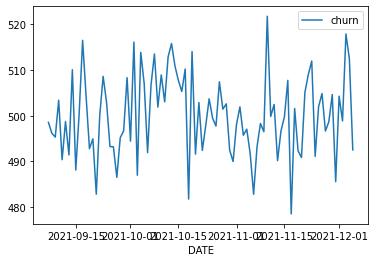

In [21]:
display(my_simple_dash())

### 5. Models/ Functions Reuse
Everything done with Metric Store is perfectly reused among many different Metrics.

Simple example bellow with forecast, but could also be used in multiple applications - supervised learning, anomaly detection, others

In [22]:
def simple_forecast(metric):
    """
    
    Simple "forecast" for illustration purpose. 
    
    Obs.: Not a recommendation of how to do forecasts!
    
    """
    from statsmodels.tsa.arima.model import ARIMA
    series = aggregate_filter(metric = metric)
    series.index = series['DATE']
    series = series[metric]
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()

    print(model_fit.summary())
    return model_fit

simple_forecast(metric = 'sales')

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   90
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -972.502
Date:                Mon, 06 Dec 2021   AIC                           1957.004
Time:                        13:27:30   BIC                           1971.936
Sample:                    09-07-2021   HQIC                          1963.023
                         - 12-05-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0356      0.013     -2.740      0.006      -0.061      -0.010
ar.L2         -0.0049      0.053     -0.092      0.927      -0.109       0.100
ar.L3          0.0086      0.063      0.137      0.8

C:\Users\Borba\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Borba\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Borba\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


### 6. Customer Interaction Data
Useful for experimentation and quasi-experimentation

In [23]:
def create_experimentation_metadata():
    """
    
    Table with Metadata from all experiments and quasi-experiments in your company.
    
    Initing with dummy values.
    
    """
    df_experim = spark.createDataFrame(pd.DataFrame.from_dict({'CAMPAIGN': ['campaign_x'], 'METRIC': ['sales'], 'TYPE': ['ab test'], 'GRANULARITY': ['CUSTOMER'], 'CHANNEL': ['push'], 'RESPONSIBLE': ['xxxx@yourcompany.com'], 'DESCRIPTION': ['Just a dummy experiment.'], 'HYPOTHESIS': ['Sending xxxx will increase customer yyyy by zzzz']}))
    df_experim.write.mode("overwrite").saveAsTable("df_experim")

create_experimentation_metadata()
df_experim = spark.sql("select * from df_experim")
df_experim.show()

+----------+------+-------+-----------+-------+--------------------+--------------------+--------------------+
|  CAMPAIGN|METRIC|   TYPE|GRANULARITY|CHANNEL|         RESPONSIBLE|         DESCRIPTION|          HYPOTHESIS|
+----------+------+-------+-----------+-------+--------------------+--------------------+--------------------+
|campaign_x| sales|ab test|   CUSTOMER|   push|xxxx@yourcompany.com|Just a dummy expe...|Sending xxxx will...|
+----------+------+-------+-----------+-------+--------------------+--------------------+--------------------+



In [24]:
def create_customer_interaction():
    """
    
    Table with customer interaction - init with dummy data
    
    """
    df_customer_interaction = spark.createDataFrame(pd.DataFrame.from_dict({'CUSTOMER': ['customer_110'], 'DATE': ['2021-10-04'], 'GROUP': ['control'], 'TYPE': ['experiment'], 'CAMPAIGN': 'campaign_x'}))
    df_customer_interaction.write.mode("overwrite").saveAsTable("df_customer_interaction")

create_customer_interaction()
df_customer_interaction = spark.sql("select * from df_customer_interaction")
df_customer_interaction.show()

+------------+----------+-------+----------+----------+
|    CUSTOMER|      DATE|  GROUP|      TYPE|  CAMPAIGN|
+------------+----------+-------+----------+----------+
|customer_110|2021-10-04|control|experiment|campaign_x|
+------------+----------+-------+----------+----------+



In [25]:
def create_experimentation_results():
    """
    
    Table with experimentation results - init with dummy data
    
    Store all results from experiments, as soon as the analysis is run!
    
    """
    df_experiment_result = spark.createDataFrame(pd.DataFrame.from_dict({'CAMPAIGN': ['dummy'], 'METRIC': ['dummy'], 'LIFT': [0], 'PVALUE': [0.5], 'COMMENTS': ['N/A']}))
    df_experiment_result.write.mode("overwrite").saveAsTable("df_experiment_result")

create_experimentation_results()
df_experiment_result = spark.sql("select * from df_experiment_result")
df_experiment_result.show()

+--------+------+----+------+--------+
|CAMPAIGN|METRIC|LIFT|PVALUE|COMMENTS|
+--------+------+----+------+--------+
|   dummy| dummy|   0|   0.5|     N/A|
+--------+------+----+------+--------+



In [26]:
def register_experiment(exp_metadata):
    """
    Run to register a new experiment or quasi-experiment. Include all relevant info for a proper governance
    
    Append data to table: df_experim
    
    """
    #global df_experim
    df_experim = spark.sql("select * from df_experim")
    exp_metadata = pd.DataFrame.from_dict(exp_metadata)
    df_experim_this = spark.createDataFrame(exp_metadata)
    df_experim = df_experim_this.union(df_experim)
    save_table(df_experim, "df_experim")

exp_metadata = {'CAMPAIGN': ['test_black_friday_001'], 'METRIC': ['sales'], 'TYPE': ['ab test'], 'GRANULARITY': ['customer'], 'CHANNEL': ['email'], 'RESPONSIBLE': ['xxxx@yourcompany.com'], 'DESCRIPTION': ['Push with coupons for active customers, aiming at increasing sales for treatment group. MDE of 1%.'], 'HYPOTHESIS': ['Sending customers coupons, via push, will result in a lift in sales that overcome the costs of coupons']}
register_experiment(exp_metadata)
df_experim = spark.sql("select * from df_experim")
df_experim.show()

+--------------------+------+-------+-----------+-------+--------------------+--------------------+--------------------+
|            CAMPAIGN|METRIC|   TYPE|GRANULARITY|CHANNEL|         RESPONSIBLE|         DESCRIPTION|          HYPOTHESIS|
+--------------------+------+-------+-----------+-------+--------------------+--------------------+--------------------+
|test_black_friday...| sales|ab test|   customer|  email|xxxx@yourcompany.com|Push with coupons...|Sending customers...|
|          campaign_x| sales|ab test|   CUSTOMER|   push|xxxx@yourcompany.com|Just a dummy expe...|Sending xxxx will...|
+--------------------+------+-------+-----------+-------+--------------------+--------------------+--------------------+



In [27]:
def add_customer_interaction(df_experim_this, campaign, type_interaction = 'experiment'):
    """
    Add each customer interaction (ab test/ quasi experimentation data)
    
    Append data to df_customer_interaction
    
    """
    #global df_customer_interaction
    df_customer_interaction = spark.sql("select * from df_customer_interaction")
    
    if type(df_experim_this) == dict:
        df_experim_this = pd.DataFrame.from_dict(df_experim_this)
        df_experim_this = spark.createDataFrame(df_experim_this)
    elif type(df_experim_this) == pyspark.sql.dataframe.DataFrame:
        pass
    else:
        print('Type not valid')
        return -1
    
    df_experim_this = df_experim_this.withColumn('TYPE', F.lit(type_interaction))
    df_experim_this = df_experim_this.withColumn('CAMPAIGN', F.lit(campaign))
    
    df_customer_interaction = df_experim_this.union(df_customer_interaction)
    save_table(df_customer_interaction, "df_customer_interaction")

exp_interact = {'CUSTOMER': ['customer_11', 'customer_76'], 'DATE': ['2021-10-04', '2021-10-04'], 'GROUP': ['control', 'treatment']}
add_customer_interaction(exp_interact, campaign = 'test_black_friday_001')
df_customer_interaction = spark.sql("select * from df_customer_interaction")
df_customer_interaction.show()

+------------+----------+---------+----------+--------------------+
|    CUSTOMER|      DATE|    GROUP|      TYPE|            CAMPAIGN|
+------------+----------+---------+----------+--------------------+
| customer_76|2021-10-04|treatment|experiment|test_black_friday...|
| customer_11|2021-10-04|  control|experiment|test_black_friday...|
|customer_110|2021-10-04|  control|experiment|          campaign_x|
+------------+----------+---------+----------+--------------------+



Note that, with the info available in experiments and metric store tables, we have all the information needed to know what was the metric behavior before and after some customer interaction, for each of the customers in each group. 

To get data from any kind of initiative with customer level information, we could use a function like that:

In [28]:
def get_experiment_data(campaign, min_range = 0, max_range = 10):
    """
    Join information from experiment and metric store.
    
    Default: return all info from 0 to 10 days after interaction (min_range=0 and max_range=10). 
    
    For pre-post analysis, for example, change parameters to, for example, min_range=-10 and max_range=10
    
    """

    df_experim = spark.sql("select * from df_experim")
    df_customer_interaction = spark.sql("select * from df_customer_interaction")
    df_metric_store = spark.sql("select * from df_metric_store")
    
    
    df_customer_interaction_this = df_customer_interaction.alias('df_customer_interaction_this')
    
    df_customer_interaction_this = df_customer_interaction_this.where(F.col('CAMPAIGN') == campaign)
    df_customer_interaction_this = df_customer_interaction_this.withColumn('DATE_min', F.date_add(F.col('DATE'), -min_range))
    df_customer_interaction_this = df_customer_interaction_this.withColumn('DATE_max', F.date_add(F.col('DATE'), max_range))

    df_customer_interaction_this = df_customer_interaction_this.withColumnRenamed('CUSTOMER', 'CUSTOMER_exp')
    df_customer_interaction_this = df_customer_interaction_this.withColumnRenamed('DATE', 'DATE_exp')
    df_experim = df_experim.withColumnRenamed('METRIC', 'METRIC_meta')

    # Filter metrics as listed in metadata
    df_metric_store_this = df_metric_store.join(df_experim, (df_metric_store.METRIC == df_experim.METRIC_meta))

    df_camp = df_metric_store_this.join(df_customer_interaction_this, (df_metric_store_this.DATE >= df_customer_interaction_this.DATE_min) &\
                                   (df_metric_store_this.DATE <= df_customer_interaction_this.DATE_max) &\
                                   (df_metric_store_this.CUSTOMER == df_customer_interaction_this.CUSTOMER_exp), how = 'inner')
    
    df_camp = df_camp.withColumn("DIFF_DAYS", F.datediff(F.col("DATE"),F.col("DATE_exp")))

    df_camp = df_camp.select(['CUSTOMER', 'DATE', 'DIFF_DAYS', 'METRIC', 'VALUE', 'GROUP'])
    df_camp = df_camp.dropDuplicates()
    return df_camp

df_camp = get_experiment_data(campaign = 'test_black_friday_001')
df_camp.show()

+-----------+----------+---------+------+-----+---------+
|   CUSTOMER|      DATE|DIFF_DAYS|METRIC|VALUE|    GROUP|
+-----------+----------+---------+------+-----+---------+
|customer_11|2021-10-11|        7| sales|528.0|  control|
|customer_76|2021-10-09|        5| sales|709.0|treatment|
|customer_11|2021-10-05|        1| sales|677.0|  control|
|customer_76|2021-10-07|        3| sales|402.0|treatment|
|customer_76|2021-10-06|        2| sales|656.0|treatment|
|customer_11|2021-10-08|        4| sales|145.0|  control|
|customer_11|2021-10-09|        5| sales| 57.0|  control|
|customer_76|2021-10-04|        0| sales|580.0|treatment|
|customer_76|2021-10-10|        6| sales|319.0|treatment|
|customer_11|2021-10-06|        2| sales|840.0|  control|
|customer_11|2021-10-13|        9| sales|783.0|  control|
|customer_76|2021-10-14|       10| sales|363.0|treatment|
|customer_76|2021-10-13|        9| sales|187.0|treatment|
|customer_76|2021-10-12|        8| sales|293.0|treatment|
|customer_11|2

### 7. Experiments
Now, hypothesis test and quasi-experiments can be run with this data

In [29]:
def hypothesis_test(campaign):
    from scipy import stats
    """
    
    Simple Hypothesis testing exa
    mple
    
    """
    df_camp = get_experiment_data(campaign = campaign)
    df_abtest=df_camp[['GROUP', 'VALUE']].toPandas()
    
    treatment = df_abtest.loc[df_abtest['GROUP'] == 'treatment', 'VALUE']
    control = df_abtest.loc[df_abtest['GROUP'] == 'control', 'VALUE']
    diff_averages = treatment.mean() - control.mean()
    
    t2, pval = stats.ttest_ind(control,treatment)
    print(f'For this campaign, the difference between treatment and control was: {round(diff_averages, 2)} with a p-value of {round(pval, 3)}')
    return diff_averages, pval

campaign = 'test_black_friday_001'
diff_averages, pval = hypothesis_test(campaign = campaign)


For this campaign, the difference between treatment and control was: -129.55 with a p-value of 0.282


In [30]:
# Table with experiments results
def register_experiment_results(exp_results):
    """
    Run to register a new experiment or quasi-experiment. Include all relevant info for a proper governance
    
    Append data to table df_experiment_result
    
    """

    df_experiment_result = spark.sql("select * from df_experiment_result")
    
    exp_results = pd.DataFrame.from_dict(exp_results)
    exp_results_this = spark.createDataFrame(exp_results)
    df_experiment_result = exp_results_this.union(df_experiment_result)
    save_table(df_experiment_result, "df_experiment_result")

# After analysis, add results in a experiment result table
exp_results = {'CAMPAIGN': [campaign], 'METRIC': ['sales'], 'LIFT': [diff_averages], 'PVALUE': [pval], 'COMMENTS': ['Results obtained xxxx']}
register_experiment_results(exp_results)
df_experiment_result = spark.sql("select * from df_experiment_result")
df_experiment_result.show()

+--------------------+------+----+------------------+--------------------+
|            CAMPAIGN|METRIC|LIFT|            PVALUE|            COMMENTS|
+--------------------+------+----+------------------+--------------------+
|test_black_friday...| sales|-129|0.2821153791072286|Results obtained ...|
|               dummy| dummy|   0|               0.5|                 N/A|
+--------------------+------+----+------------------+--------------------+



In [31]:
# Quasi-experiment example: diff in diff applied to Loyalty lvl 6, using as reference customers that navigates in loyalty level 6 acquisition page.
# For diff-in-diff, need to know: Date Range, Window size, control metric, treatment metric, target metric

def diff_in_diff(analysis_name, description, hypothesis, responsible, target_metric, data_rage, control_metric, control_variation, treat_metric, treat_variation, channel, window_size = 10, granularity = 'customer'):

    """
    
    Quasi-experiment using the data of experiments + metric store. Other observational models can also be used, besides diff-in-diff
    
    
    """
    from pyspark.ml.regression import GeneralizedLinearRegression
    # First, register a new observation on experiment datadata
    exp_metadata = {'CAMPAIGN': [analysis_name], 'METRIC': [target_metric], 'TYPE': ['observational'], 'GRANULARITY': [granularity], 'CHANNEL': [channel], 'RESPONSIBLE': [responsible], 'DESCRIPTION': [description], 'HYPOTHESIS': [hypothesis]}
    register_experiment(exp_metadata)
    
    df_metric_store = spark.sql("select * from df_metric_store")
    
    # Defining the 'control' group: everyone that navigates in the webpage during the date range specified
    df_control = df_metric_store.where((F.col('METRIC') == control_metric) &\
                                       (F.col('VARIATION') == control_variation) &\
                                      (F.col('DATE') >= F.lit(data_rage[0])) &\
                                       (F.col('DATE') <= F.lit(data_rage[1])))
    df_control = df_control.withColumn('GROUP', F.lit('control'))
    df_control = df_control.select(['CUSTOMER', 'DATE', 'GROUP'])
    
    # Defining the 'treatment' group: everyone that purchase loyalty 6
    df_treat= df_metric_store.where((F.col('METRIC') == treat_metric) &\
                                       (F.col('VARIATION') == treat_variation) &\
                                      (F.col('DATE') >= F.lit(data_rage[0])) &\
                                       (F.col('DATE') <= F.lit(data_rage[1])))

    df_treat = df_treat.withColumn('GROUP', F.lit('treatment'))
    df_treat = df_treat.select(['CUSTOMER', 'DATE', 'GROUP'])
    
    # Log customer information on customer interaction table
    df_quasi_exp = df_treat.union(df_control)
    add_customer_interaction(df_quasi_exp, campaign = analysis_name, type_interaction = 'observational')
    
    # Get all information from target metric
    filter_quasi_exp = get_experiment_data(campaign = analysis_name,  min_range = -window_size, max_range = window_size)
    
    # Create diff in diff features
    filter_quasi_exp = filter_quasi_exp.withColumn('after', F.when(F.col('DIFF_DAYS') >= 0, 1).otherwise(0))
    filter_quasi_exp = filter_quasi_exp.withColumn('treat', F.when(F.col('GROUP') == 'treatment', 1).otherwise(0))
    filter_quasi_exp = filter_quasi_exp.withColumn('after_treat', F.col('after') * F.col('treat'))

    # Create data frame for linear model
    vectorAssembler = VectorAssembler(inputCols = ['after', 'treat', 'after_treat'], outputCol = 'features')
    df_model = vectorAssembler.transform(filter_quasi_exp)
    df_model = df_model.select(['features', 'VALUE'])
    
    # Run model
    #glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
    lr=GeneralizedLinearRegression(featuresCol = 'features', labelCol='VALUE',family="gaussian",maxIter=10,regParam=0.3)
    #lr = LinearRegression(featuresCol = 'features', labelCol='VALUE', maxIter=10, regParam=0.3, elasticNetParam=0.8)
    lr_model = lr.fit(df_model)
    
    # Printing Results
    print(f"Analyzing influence of {treat_metric} {treat_variation} in metric {target_metric}, using {control_metric} {control_variation} as reference. Using all events between {data_rage[0]} and {data_rage[1]} and considering target metric {window_size} days before and after the event.")

    
    ave_lift = round(lr_model.coefficients[2],2)
    pvalue = round(lr_model.summary.pValues[2],2)
    print(f'Average Estimated Effect: {ave_lift}, p-value: {pvalue}')
    
    
    exp_results = {'CAMPAIGN': [analysis_name], 'METRIC': [target_metric], 'LIFT': [ave_lift], 'PVALUE': [pvalue], 'COMMENTS': ['Results obtained From Diff-in-Diff on 2021-06-12']}
    register_experiment_results(exp_results)

    
    return lr_model
    
    
dict_input_quasi={
    'analysis_name': 'loyalty_lvl6_analysis',
    'description': 'Observational Analysis of Loyalty Lvl 6, given navigation in signature webpage.',
    'hypothesis': 'People that acquired loyalty lvl6 increase sales',
    'responsible': 'xxxx@yourcompany.com',
    'target_metric': 'sales',
    'data_rage': ['2021-10-30', '2021-10-30'],
    'control_metric': 'web_navigation',
    'control_variation': 'https://www.mercadolivre.com.br/assinaturas/nivel-6',
    'treat_metric': 'loyalty_acquisition',
    'treat_variation': '6',
    'channel': 'web'
}


lr_model = diff_in_diff(**dict_input_quasi)

Analyzing influence of loyalty_acquisition 6 in metric sales, using web_navigation https://www.mercadolivre.com.br/assinaturas/nivel-6 as reference. Using all events between 2021-10-30 and 2021-10-30 and considering target metric 10 days before and after the event.
Average Estimated Effect: 16.04, p-value: 1.0


In [32]:
# See that diff-in-diff call save information in experiment result with TYPE = 'observational'

df_experiment_result = spark.sql("select * from df_experiment_result")
df_experim = spark.sql("select * from df_experim")
df_exp_diff = df_experim.join(df_experiment_result, ['CAMPAIGN', 'METRIC'], how = 'left')
df_exp_diff = df_exp_diff.select(['CAMPAIGN', 'METRIC', 'TYPE', 'RESPONSIBLE', 'DESCRIPTION', 'LIFT', 'PVALUE', 'COMMENTS'])
df_exp_diff.show()


+--------------------+------+-------------+--------------------+--------------------+----+------------------+--------------------+
|            CAMPAIGN|METRIC|         TYPE|         RESPONSIBLE|         DESCRIPTION|LIFT|            PVALUE|            COMMENTS|
+--------------------+------+-------------+--------------------+--------------------+----+------------------+--------------------+
|test_black_friday...| sales|      ab test|xxxx@yourcompany.com|Push with coupons...|-129|0.2821153791072286|Results obtained ...|
|loyalty_lvl6_anal...| sales|observational|xxxx@yourcompany.com|Observational Ana...|  16|               1.0|Results obtained ...|
|          campaign_x| sales|      ab test|xxxx@yourcompany.com|Just a dummy expe...|null|              null|                null|
+--------------------+------+-------------+--------------------+--------------------+----+------------------+--------------------+



### 8. Example - Knowledge Management
Example of how this architecture could improve experimentation and analysis governance and knowledge management.

For example, if your goal is to increase 'sales', you can access all previous experiments and measurements that used 'sales' as metric, using push as channel

In [33]:
def get_filtered_experiments(query_experiment_metri, query_experiment_channel):
    df_experim = spark.sql("select * from df_experim")
    df_experim_filter = df_experim.where((F.col('METRIC') == query_experiment_metri) & (F.col('CHANNEL') == query_experiment_channel))
    df_experim_filter = df_experim_filter.join(df_experiment_result, ['CAMPAIGN'], how = 'left')                            
    return df_experim_filter

filter_exp = get_filtered_experiments(query_experiment_metri = 'sales', query_experiment_channel = 'push')
filter_exp.show()

+----------+------+-------+-----------+-------+--------------------+--------------------+--------------------+------+----+------+--------+
|  CAMPAIGN|METRIC|   TYPE|GRANULARITY|CHANNEL|         RESPONSIBLE|         DESCRIPTION|          HYPOTHESIS|METRIC|LIFT|PVALUE|COMMENTS|
+----------+------+-------+-----------+-------+--------------------+--------------------+--------------------+------+----+------+--------+
|campaign_x| sales|ab test|   CUSTOMER|   push|xxxx@yourcompany.com|Just a dummy expe...|Sending xxxx will...|  null|null|  null|    null|
+----------+------+-------+-----------+-------+--------------------+--------------------+--------------------+------+----+------+--------+



### 4. Checking a customer Life
Having everything in a single table facilitates questions like: 'show me everything customer X in the last Y days'.
Very handful for CRM, customer support, customers LTV/clusterization

In [34]:
def give_all_customer_history(customer, variation = 'N/A'):
    """
    
    Simple query to return all data from a customer
    
    """
    df_metric_store = spark.sql("select * from df_metric_store")
    df_metric = df_metric_store.filter((F.col('CUSTOMER') == customer) & (F.col('VARIATION') == variation)).select('DATE', 'METRIC','VALUE')
    df_metric = df_metric.toPandas()
    df_metric = df_metric.sort_values('DATE')
    return df_metric

give_all_customer_history(customer = 'customer_11')

,DATE,METRIC,VALUE
0,2021-09-07,churn,0.663
90,2021-09-07,sales,230.000
91,2021-09-08,sales,322.000
1,2021-09-08,churn,0.166
2,2021-09-09,churn,0.704
...,...,...,...
87,2021-12-03,churn,0.508
178,2021-12-04,sales,379.000
88,2021-12-04,churn,0.316
89,2021-12-05,churn,0.838


### 9. Scheduling Queries
With metadata and governance table, find bellow a simple loop that could be used to run the queries, according to the field QUERY and FREQUENCY

In [35]:
# Finally, my process would run something like
def my_dummy_query_runner():
    import time
    
    # Check what metrics are with status "Approved"
    run_this_metrics = df_metadata.join(df_metricgov.where(F.col('STATUS') == 'Approved'), ['METRIC', 'TYPE'], how = 'inner').toPandas()
    
    def start_a_parallel_etl_job(query):
        # Start your ETL process in parallel
        print(f'Running Query: {query}')
        pass
    print("Valid Metrics:")
    print(run_this_metrics)
    
    count=0
    while count<1:
        # For all valid metrics
        for idx, row in run_this_metrics.iterrows():
            
            # Check if the metric cron expression matches right now
            time_to_run_this_query = croniter.match(row['FREQUENCY'], datetime.datetime.now())
            
            if time_to_run_this_query:
                # Start the ETL
                start_a_parallel_etl_job(row['QUERY'])
                
        # Wait a minute until the next iteration
        #time.sleep(60)
        time.sleep(1)
        count +=1
        
my_dummy_query_runner()

Valid Metrics:
  METRIC      TYPE           RESPONSIBLE  \
0  sales  business  xxxx@yourcompany.com   

                                         DESCRIPTION  FREQUENCY  \
0  Total sales of a given customer across all cha...  0 8 * * *   

                                           QUERY    STATUS  
0  select ....from db.customer join ... where...  Approved  


Some advantages of centralizing metric computations, include:
- governance
- maintenance
- DRY health check/ anomaly detection
- query statistics

### 7. Summary and Final comments

**Important**: All python functions could be API calls, to better integrate and facilitate the development of a product, with an user interface. This is just a toy problem, real implementations of Metric Store and Measurement Architecture can have different complexities.

In summary, after all functions definitions, we created a DRY-based architecture, in which all components are reusable, ready to democratize measurement in your company.


##### For every new metric:
Register in a datacatalog

```df_metadata = create_new_metric(name = 'new_metric', type_metric = 'business', responsible = 'zzzz@yourcompany.com', description = 'Just a dummy metric', frequency = '0 9 * * *')```

##### When new metric is available (ex, once a day):
Upload data to Metric Store

```df_metric_store = upload_metric(df_append_store, date = '2021-11-30', metric = 'sales')```

##### For every new experiment:
Register in a experiment catalog

```register_experiment(exp_metadata)```

##### For every customer interaction:

Whatever the source (email, push, third-party online campaigns, others), add information of customer, data, campaign and group in the experimentation table

```df_experim = add_customer_interaction(df_experim)```

This is a very simple example, but sufficient to illustrate a number of advantages of having a centralized, **DRY**-based measurement and experimentation framework.
For this simple case, all metrics were aggregated by customer and date. Usually this hypothesis covers most of the cases, but similar architecture can be developed for intraday analysis (interactin by interaction)

For drilldown analysis (ex. sales in a specific region), the suggestion is to add a customer dimension with dates.

Other applications:
- Adding a cost table can be used for budget optimization and models like MMM, FFM, RBA
- Supervised Learning (filter, pivot/ aggregation, train/ test split, model)